<a href="https://colab.research.google.com/github/BhardwajArjit/Causality-Informed-Segmentation/blob/main/Semantic_Segmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import math
import torch
import torchvision

from torch import nn
from torch.nn import init
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms

In [5]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=out_channels,
                  out_channels=out_channels,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

In [6]:
class UNet(nn.Module):
  def __init__(self,
               in_channels=3,
               out_channels=1,
               features=[64, 128, 256, 512]):
    super().__init__()

    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2,
                             stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels=in_channels,
                                   out_channels=feature))
      in_channels=feature


    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(in_channels=feature*2,
                                         out_channels=feature,
                                         kernel_size=2,
                                         stride=2))
      self.ups.append(DoubleConv(in_channels=feature*2,
                                 out_channels=feature))

    self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
    self.final_conv = nn.Conv2d(in_channels=features[0],
                                out_channels=out_channels,
                                kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx // 2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx + 1](concat_skip)

    return self.final_conv(x)

In [7]:
def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)

  assert preds.shape == x.shape

In [8]:
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [9]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "cityscapes_data"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "cityscapes_data.zip", "wb") as f:
  request = requests.get("https://github.com/BhardwajArjit/Causality-Informed-Segmentation/raw/main/cityscapes_data.zip")
  print("Downloading nico subset data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "cityscapes_data.zip", "r") as zip_ref:
  print(f"Uzipping cityscapes data...")
  zip_ref.extractall(data_path)

data/cityscapes_data does not exist, creating one...
Uzipping cityscapes data...


In [10]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [19]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/cityscapes_data'.
There are 0 directories and 500 images in 'data/cityscapes_data/val'.
There are 0 directories and 2975 images in 'data/cityscapes_data/train'.


In [12]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/cityscapes_data/train'),
 PosixPath('data/cityscapes_data/test'))

In [15]:
image_path

PosixPath('data/cityscapes_data')

Random image path: data/cityscapes_data/train/2957.jpg
Image class: train
Image height: 256
Image width: 512


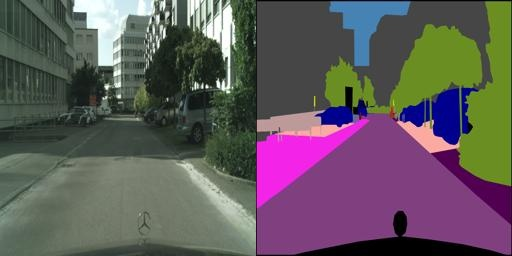

In [18]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("train/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img